# SMAP Project

## Installation and import

In [1]:
%pip install -q tfds-nightly tensorflow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load and visualize the dataset

In [3]:
batch_size = 32
img_height = 256
img_width = 256
data_dir = r'C:\Users\Admin\tensorflow_datasets\NWPU-RESISC45'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 31500 files belonging to 45 classes.
Using 25200 files for training.
Found 31500 files belonging to 45 classes.
Using 6300 files for validation.
['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'railway_station', 'rectangular_farmland', 'river', 'roundabout', 'runway', 'sea_ice', 'ship', 'snowberg', 'sparse_residential', 'stadium', 'storage_tank', 'tennis_court', 'terrace', 'thermal_power_station', 'wetland']


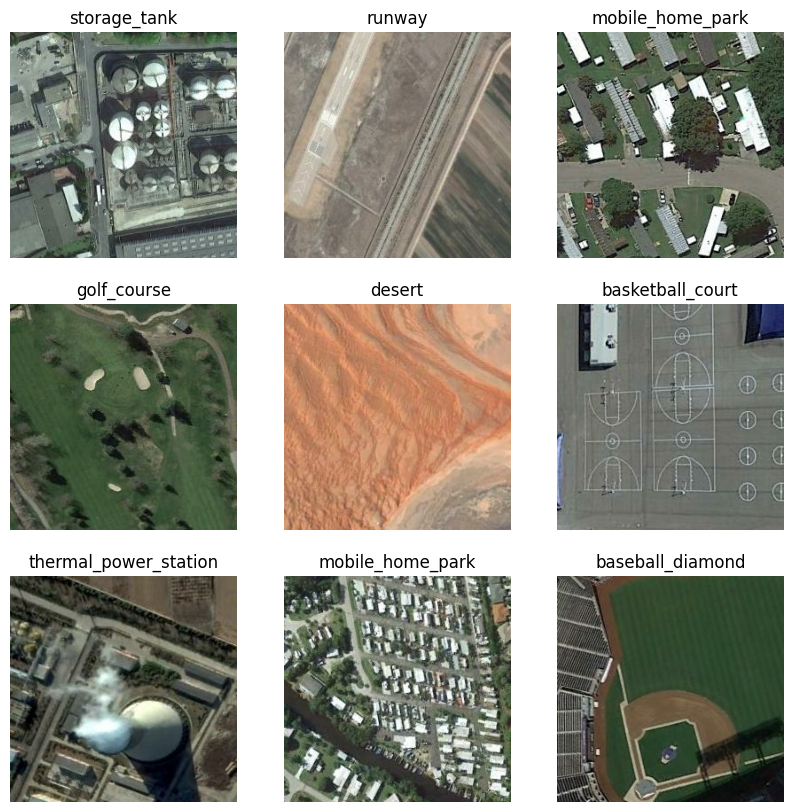

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


## Preprocess dataset

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Check
print(np.min(first_image), np.max(first_image))

0.0 0.9450981


## Create Model and Train

In [8]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [47]:
epochs=10

In [11]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


788/788 [==============================] - 365s 462ms/step - loss: 2.6388 - accuracy: 0.2729 - val_loss: 2.1405 - val_accuracy: 0.3814
Epoch 2/10
788/788 [==============================] - 358s 454ms/step - loss: 1.6715 - accuracy: 0.5185 - val_loss: 1.8134 - val_accuracy: 0.4860
Epoch 3/10
788/788 [==============================] - 356s 452ms/step - loss: 1.0303 - accuracy: 0.6956 - val_loss: 1.9092 - val_accuracy: 0.4865
Epoch 4/10
788/788 [==============================] - 350s 444ms/step - loss: 0.4976 - accuracy: 0.8543 - val_loss: 2.4002 - val_accuracy: 0.4754
Epoch 5/10
788/788 [==============================] - 352s 447ms/step - loss: 0.2365 - accuracy: 0.9319 - val_loss: 3.0069 - val_accuracy: 0.4827
Epoch 6/10
788/788 [==============================] - 352s 447ms/step - loss: 0.1415 - accuracy: 0.9579 - val_loss: 3.4879 - val_accuracy: 0.4648
Epoch 7/10
788/788 [==============================] - 352s 446ms/step - loss: 0.1203 - accuracy: 0.9648 - val_loss: 3.6891 - val_accura

## Visualization of results

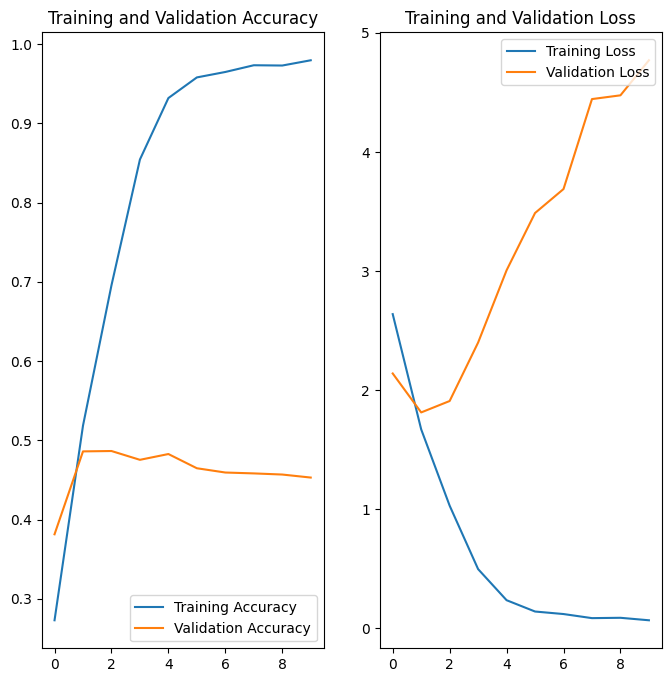

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* the graphs show that the training accuracy increases linearly over time, while the validation accuracy stops before 50% in the training process
* the difference in accuracy between training and validation is large, which could point to an overfitting problem
* I will try to add data augmentation and dropout to fix this problem

## Augmentation 

In [41]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

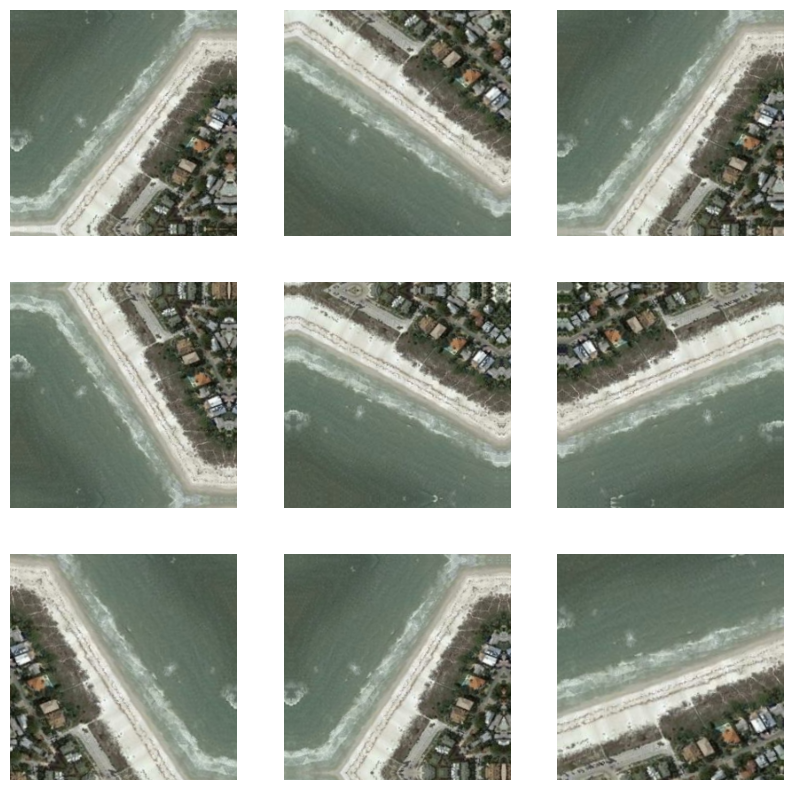

In [42]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Second Model and Training

In [43]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                 

In [45]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
788/788 [==============================] - 428s 541ms/step - loss: 2.8137 - accuracy: 0.2336 - val_loss: 2.4235 - val_accuracy: 0.3325
Epoch 2/10
788/788 [==============================] - 417s 530ms/step - loss: 1.9644 - accuracy: 0.4328 - val_loss: 1.8912 - val_accuracy: 0.4757
Epoch 3/10
788/788 [==============================] - 414s 526ms/step - loss: 1.6213 - accuracy: 0.5272 - val_loss: 1.6566 - val_accuracy: 0.5227
Epoch 4/10
788/788 [==============================] - 413s 524ms/step - loss: 1.4323 - accuracy: 0.5790 - val_loss: 1.4329 - val_accuracy: 0.5897
Epoch 5/10
788/788 [==============================] - 414s 526ms/step - loss: 1.3151 - accuracy: 0.6091 - val_loss: 1.7593 - val_accuracy: 0.5086
Epoch 6/10
788/788 [==============================] - 412s 523ms/step - loss: 1.2245 - accuracy: 0.6325 - val_loss: 1.3462 - val_accuracy: 0.6100
Epoch 7/10
788/788 [==============================] - 414s 526ms/step - loss: 1.1606 - accuracy: 0.6554 - val_loss: 1.3026 -

## Visualization of results

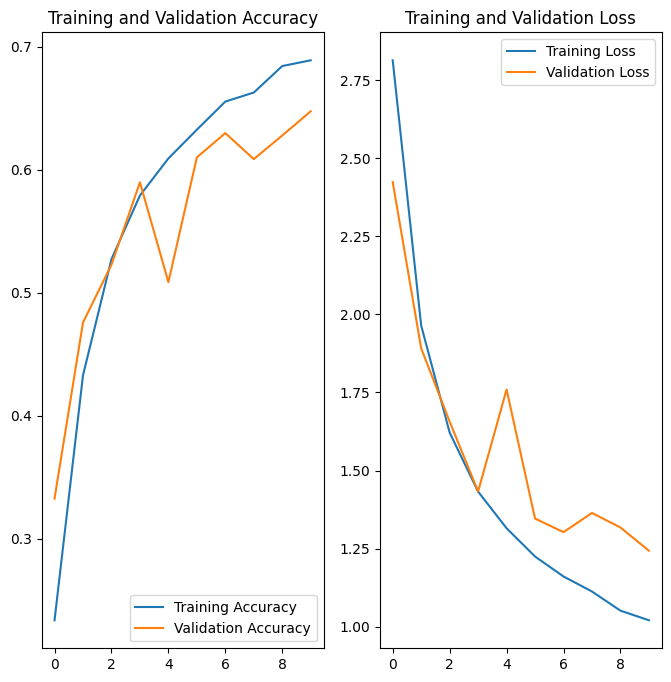

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* here we can see much better results
* training and validation accuracy/loss is holding near each other
* because accuracy/loss was still increasing/decreasing over epochs I will try add some more epochs on the same model and run again

## Third training

In [49]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


788/788 [==============================] - 411s 521ms/step - loss: 0.9920 - accuracy: 0.6971 - val_loss: 1.1869 - val_accuracy: 0.6619
Epoch 2/10
788/788 [==============================] - 415s 527ms/step - loss: 0.9662 - accuracy: 0.7063 - val_loss: 1.2013 - val_accuracy: 0.6554
Epoch 3/10
788/788 [==============================] - 411s 522ms/step - loss: 0.9366 - accuracy: 0.7136 - val_loss: 1.1615 - val_accuracy: 0.6763
Epoch 4/10
788/788 [==============================] - 408s 518ms/step - loss: 0.9108 - accuracy: 0.7201 - val_loss: 1.1308 - val_accuracy: 0.6746
Epoch 5/10
788/788 [==============================] - 406s 515ms/step - loss: 0.8959 - accuracy: 0.7238 - val_loss: 1.0896 - val_accuracy: 0.6821
Epoch 6/10
788/788 [==============================] - 444s 564ms/step - loss: 0.8831 - accuracy: 0.7275 - val_loss: 1.1403 - val_accuracy: 0.6789
Epoch 7/10
788/788 [==============================] - 414s 525ms/step - loss: 0.8472 - accuracy: 0.7351 - val_loss: 1.0549 - val_accura

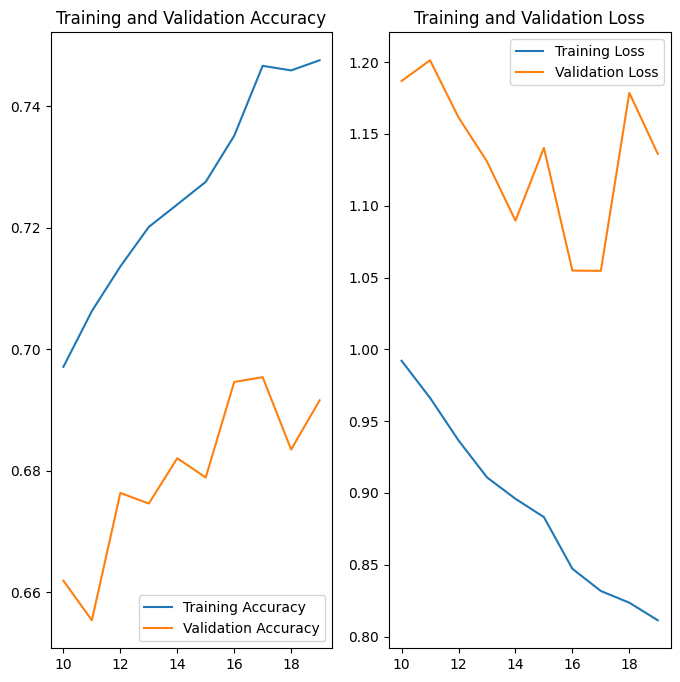

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
epochs_range = [num + epochs for num in epochs_range]

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* it looks like 18th epoch (17th on image due to starting on 0) give us best results
* loss: 0.8317 - accuracy: 0.7466 - val_loss: 1.0546 - val_accuracy: 0.6954

## Predictions on new data

In [51]:
image_path = r'C:\Users\Admin\tensorflow_datasets\VisDrone2019-DET-val\intersection.jpg'

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 98ms/step
This image most likely belongs to intersection with a 90.35 percent confidence.
